# Introduction

In this notebook, we now take our models for stock price predictions and leverage it to gain insights into OCUL, SLSB and URGN price predictions for next day, next week, next month. Note that this relies on the implicit assumption that all other market factors are priced in, in the actual stock market price. Essentially this assumes prices are set by a free market.

We can now use our model to gain insight into what stock price daily, weekly, monthly evolution could/should be, and how that might change under various scenarios.

In [19]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate

In [20]:
import datetime
import pickle

import warnings
warnings.filterwarnings('ignore')

# python packages to perform Regressions
import statsmodels.api as sm
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_pacf


from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from sklearn.svm import LinearSVC

import functools as ft


from IPython.display import display
from library.sb_utils import save_file

In [21]:
# For time stamps


from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load model

In [22]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = '../models/ARIMA_OCUL_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model version doesn't match version loaded


# Load Data

In [23]:
df_3_daily = pd.read_csv('../data/Preprocessed_data/df_3_daily.csv')
df_3_weekly = pd.read_csv('../data/Preprocessed_data/df_3_weekly.csv')
df_3_monthly = pd.read_csv('../data/Preprocessed_data/df_3_monthly.csv')


In [24]:
df_3_daily

,const,OCUL_Close,OCUL_ret,SLDB_Close,SLDB_ret,URGN_Close,URGN_ret
0,1.0,4.31,0.011737,10.215,-0.021552,8.060000,-0.009828
1,1.0,4.45,0.032483,10.050,-0.016153,8.320000,0.032258
2,1.0,4.30,-0.033708,10.740,0.068657,8.160000,-0.019231
3,1.0,4.48,0.041860,10.125,-0.057263,7.840000,-0.039216
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
723,1.0,7.75,-0.031250,7.800,-0.124579,16.639999,-0.014802
724,1.0,7.85,0.012903,8.220,0.053846,15.790000,-0.051082
725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_3_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   const       500 non-null    float64
 1   OCUL_Close  500 non-null    float64
 2   OCUL_ret    500 non-null    float64
 3   SLDB_Close  500 non-null    float64
 4   SLDB_ret    500 non-null    float64
 5   URGN_Close  500 non-null    float64
 6   URGN_ret    500 non-null    float64
dtypes: float64(7)
memory usage: 39.9 KB


In [26]:
df_3_weekly

,const,OCUL_Close,OCUL_ret,SLDB_Close,SLDB_ret,URGN_Close,URGN_ret
0,1.0,4.48,0.041860,10.125,-0.057263,7.840000,-0.039216
1,1.0,4.96,0.020576,11.385,0.012000,8.570000,0.032530
2,1.0,5.48,0.003663,12.000,0.026958,8.530000,0.024010
3,1.0,5.23,-0.022430,12.600,0.037037,8.230000,0.006112
4,1.0,5.08,-0.083032,10.950,-0.002732,7.840000,-0.067776
...,...,...,...,...,...,...,...
100,1.0,6.84,0.011834,5.670,-0.012195,16.780001,-0.011196
101,1.0,6.67,-0.002990,5.870,-0.016750,15.880000,0.057961
102,1.0,8.13,0.069737,7.910,-0.034188,16.930000,0.002368
103,1.0,7.85,0.012903,8.220,0.053846,15.790000,-0.051082


In [27]:
df_3_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   const       105 non-null    float64
 1   OCUL_Close  105 non-null    float64
 2   OCUL_ret    105 non-null    float64
 3   SLDB_Close  105 non-null    float64
 4   SLDB_ret    105 non-null    float64
 5   URGN_Close  105 non-null    float64
 6   URGN_ret    105 non-null    float64
dtypes: float64(7)
memory usage: 5.9 KB


In [28]:
df_3_monthly

,const,OCUL_Close,OCUL_ret,SLDB_Close,SLDB_ret,URGN_Close,URGN_ret
0,1.0,4.48,0.041860,10.125,-0.057263,7.840000,-0.039216
1,1.0,5.08,0.003953,9.600,-0.031770,7.450000,0.033287
2,1.0,4.15,-0.191033,7.005,-0.002137,8.320000,0.012165
3,1.0,3.61,-0.019022,6.410,0.049100,11.850000,-0.009197
4,1.0,2.97,0.034843,6.700,0.018237,8.570000,0.030048
5,1.0,2.81,0.003571,5.380,-0.074010,8.870000,0.061005
6,1.0,3.91,0.007732,7.580,0.002645,10.390000,0.026680
7,1.0,6.04,0.013423,5.620,-0.015762,10.300000,0.016782
8,1.0,5.27,0.021318,4.740,0.046358,9.240000,0.102625
9,1.0,6.20,0.031614,4.880,0.006186,11.590000,-0.069823


In [29]:
df_3_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   const       25 non-null     float64
 1   OCUL_Close  25 non-null     float64
 2   OCUL_ret    25 non-null     float64
 3   SLDB_Close  25 non-null     float64
 4   SLDB_ret    25 non-null     float64
 5   URGN_Close  25 non-null     float64
 6   URGN_ret    25 non-null     float64
dtypes: float64(7)
memory usage: 1.5 KB


# Fit ARIMA Model On OCUL Daily Data 

In [30]:
# Make predictions for future 20 values
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(1,1,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Assign residuals to variable
residuals_daily_OCUL = result_ARIMA_OCUL.resid
residuals_daily_OCUL

0      4.310000
1      0.140000
2     -0.152137
3      0.180313
4           NaN
         ...   
723   -0.260589
724    0.093863
725         NaN
726         NaN
727   -0.009441
Length: 728, dtype: float64

In [31]:
# Make predictions for last 20 values
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(2,0,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Make in-sample prediction

forecast_daily_OCUL = result_ARIMA_OCUL.get_prediction(start = -20)

# forecast mean

mean_forecast_daily_OCUL = forecast_daily_OCUL.predicted_mean
mean_forecast_daily_OCUL

708    6.659501
709    6.680749
710    6.660196
711    6.660879
712    6.640605
713    6.631711
714    6.639846
715    6.442198
716    7.138389
717    7.579331
718    8.098825
719    8.070802
720    8.040253
721    8.399077
722    8.365577
723    7.972006
724    7.722838
725    7.824930
726    7.796510
727    7.771965
Name: predicted_mean, dtype: float64

In [32]:
mae_forecast_daily_last_20 = np.mean(np.abs(mean_forecast_daily_OCUL))

OCUL_daily_actual_20 =df_3_daily['OCUL_Close'].iloc[-20:]

mae_daily_actual_last_20 = np.mean(np.abs(OCUL_daily_actual_20))

print('The mean absolute error for actual daily OCUL values are: ', mae_daily_actual_last_20)
print('The mean absolute error for predicted daily OCUL values are: ', mae_forecast_daily_last_20)


The mean absolute error for actual daily OCUL values are:  7.511538432153847
The mean absolute error for predicted daily OCUL values are:  7.389809359016743


In [33]:
# Make predictions for last 30 values
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(2,0,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Make in-sample prediction

forecast_OCUL_dynamic = result_ARIMA_OCUL.get_prediction(start = -30, dynamic=True)

# forecast mean

mean_forecast_dyn_OCUL = forecast_OCUL_dynamic.predicted_mean

mean_forecast_dyn_OCUL

698    6.229182
699    6.225502
700    6.208789
701    6.205232
702    6.188813
703    6.185376
704    6.169246
705    6.165925
706    6.150079
707    6.146871
708    6.131304
709    6.128206
710    6.112912
711    6.109923
712    6.094897
713    6.092012
714    6.077250
715    6.074467
716    6.059964
717    6.057281
718    6.043031
719    6.040445
720    6.026445
721    6.023953
722    6.010197
723    6.007797
724    5.994282
725    5.991972
726    5.978692
727    5.976469
Name: predicted_mean, dtype: float64

In [34]:
# Make predictions for future 20 values
model_ARIMA_OCUL= ARIMA(df_3_daily['OCUL_Close'], order=(2,1,1))
result_ARIMA_future_OCUL = model_ARIMA_OCUL.fit()

# Make in-sample prediction

forecast_future_OCUL = result_ARIMA_future_OCUL.get_forecast(steps = 20)

# forecast mean

mean_forecast_future_OCUL = forecast_future_OCUL.predicted_mean
mean_forecast_future_OCUL

728    7.862539
729    7.864982
730    7.867110
731    7.868980
732    7.870624
733    7.872068
734    7.873336
735    7.874450
736    7.875429
737    7.876290
738    7.877045
739    7.877709
740    7.878292
741    7.878805
742    7.879255
743    7.879650
744    7.879998
745    7.880303
746    7.880571
747    7.880807
Name: predicted_mean, dtype: float64

In [35]:
mae_forecast_future_20 = np.mean(np.abs(forecast_OCUL_dynamic.predicted_mean))

OCUL_actual_next_20 =df_3_daily['OCUL_Close'].iloc[-20:]

mae_actual_next_20 = np.mean(np.abs(OCUL_actual_next_20))

print('The mean absolute error for actual next OCUL values are: ', mae_actual_next_20)
print('The mean absolute error for predicted future OCUL values are: ', mae_forecast_future_20)

The mean absolute error for actual next OCUL values are:  7.511538432153847
The mean absolute error for predicted future OCUL values are:  6.096883769294792


# How far are OCUL daily stock price predictions from the true values, on average.

In [37]:
mae = np.mean(np.abs(residuals_daily_OCUL))
mae

0.18973246069471034

# Fit ARIMA Model On OCUL Weekly Data 

In [48]:
# Make predictions for future 20 values
model_ARIMA_OCUL= ARIMA(df_3_weekly['OCUL_Close'], order=(1,1,1))
result_weekly_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Assign residuals to variable
residuals_weekly_OCUL = result_weekly_ARIMA_OCUL.resid
residuals_weekly_OCUL

0      4.480000
1      0.480000
2      0.471813
3     -0.312411
4     -0.140379
         ...   
100    0.526639
101   -0.242802
102    1.459320
103   -0.423024
104    0.003382
Length: 105, dtype: float64

In [49]:
# Make predictions for last 30 values
model_ARIMA_OCUL= ARIMA(df_3_weekly['OCUL_Close'], order=(2,0,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Make in-sample prediction

forecast_weekly_OCUL = result_ARIMA_OCUL.get_prediction(start = -20)

# forecast mean

mean_weekly_forecast_OCUL = forecast_weekly_OCUL.predicted_mean
mean_weekly_forecast_OCUL

85     9.718825
86     9.106060
87     9.095490
88     8.665987
89     7.983448
90     7.541771
91     4.743554
92     4.381723
93     5.944252
94     5.450747
95     6.009972
96     5.636870
97     5.560754
98     4.803737
99     5.672257
100    6.183638
101    6.768335
102    6.560267
103    8.031519
104    7.678162
Name: predicted_mean, dtype: float64

In [52]:
mae_weekly_forecast_last_20 = np.mean(np.abs(mean_weekly_forecast_OCUL))

OCUL_weekly_actual_20 =df_3_weekly['OCUL_Close'].iloc[-20:]

mae_weekly_actual_last_20 = np.mean(np.abs(OCUL_weekly_actual_20))

print(mae_weekly_actual_last_20)
print(mae_weekly_forecast_last_20)
print()
print('The mean absolute error for actual weekly OCUL values are: ', mae_weekly_actual_last_20)
print('The mean absolute error for predicted weekly OCUL values are: ', mae_weekly_forecast_last_20)

6.911499976999998
6.776868423526291

The mean absolute error for actual weekly OCUL values are:  6.911499976999998
The mean absolute error for predicted weekly OCUL values are:  6.776868423526291


# How far are OCUL weekly stock price predictions from the true values, on average.

In [51]:
mae = np.mean(np.abs(residuals_weekly_OCUL))
mae

0.5017219449432536

# Fit ARIMA Model On OCUL Monthly Data 

In [53]:
# Make predictions for future 20 values
model_ARIMA_OCUL= ARIMA(df_3_monthly['OCUL_Close'], order=(1,1,1))
result_ARIMA_OCUL = model_ARIMA_OCUL.fit()

# Assign residuals to variable
residuals_monthly_OCUL = result_ARIMA_OCUL.resid
residuals_monthly_OCUL

0     4.480000
1     0.600002
2    -0.829579
3    -0.632650
4    -0.832669
5    -0.470962
6     0.786771
7     2.113425
8    -0.259443
9     1.199519
10    0.684657
11   -0.743770
12   -0.490496
13   -0.805640
14   -0.886292
15   -0.691324
16   -0.821454
17    1.459041
18    0.459352
19    5.365722
20    0.634807
21   -3.137429
22    0.888223
23    1.340855
24    1.526798
dtype: float64

In [55]:
# Make predictions for last 30 values
model_ARIMA_OCUL= ARIMA(df_3_monthly['OCUL_Close'], order=(2,0,1))
result_ARIMA_monthly_OCUL = model_ARIMA_OCUL.fit()

# Make in-sample prediction

forecast_monthly_OCUL = result_ARIMA_monthly_OCUL.get_prediction(start = -20)

# forecast mean

mean_monthly_forecast_OCUL = forecast_monthly_OCUL.predicted_mean
mean_monthly_forecast_OCUL

5     3.712959
6     3.884324
7     4.615491
8     6.002033
9     4.820085
10    6.219102
11    5.599371
12    5.061028
13    4.721561
14    4.241259
15    3.926961
16    3.799894
17    3.542549
18    5.225558
19    4.749661
20    9.264269
21    6.354281
22    4.672529
23    5.832373
24    6.123778
Name: predicted_mean, dtype: float64

In [59]:
mae_monthly_forecast_last_20 = np.mean(np.abs(mean_monthly_forecast_OCUL))

OCUL_monthly_actual_20 =df_3_monthly['OCUL_Close'].iloc[-20:]

mae_monthly_actual_last_20 = np.mean(np.abs(OCUL_monthly_actual_20))

print(mae_monthly_actual_last_20)
print(mae_monthly_forecast_last_20)
print()
print('The mean absolute error for monthly actual OCUL values are: ', mae_monthly_actual_last_20)
print('The mean absolute error for monthly predicted last OCUL values are: ', mae_monthly_forecast_last_20)

5.310000026250001
5.11845338014836

The mean absolute error for monthly actual OCUL values are:  5.310000026250001
The mean absolute error for monthly predicted last OCUL values are:  5.11845338014836


# How far are OCUL monthly stock price predictions from the true values, on average.

In [68]:
mae = np.mean(np.abs(residuals_monthly_OCUL))
mae

1.2856351975782871

# Model Random Forest & Decision Tree

In [69]:
# load data

df = pd.read_csv('../data/Preprocessed_data/df_cleaned_02.csv')

# Set the 'Date' column back to the index
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1503 entries, 2022-07-25 to 2024-07-22
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ticker_symbol  1503 non-null   object 
 1   company_name   1503 non-null   object 
 2   Open           1503 non-null   float64
 3   High           1503 non-null   float64
 4   Low            1503 non-null   float64
 5   Close          1503 non-null   float64
 6   Adj Close      1503 non-null   float64
 7   Volume         1503 non-null   int64  
 8   Daily_Return   1500 non-null   float64
 9   30_MA          1416 non-null   float64
 10  90_MA          1236 non-null   float64
 11  RSI            1464 non-null   float64
 12  MACD           1503 non-null   float64
 13  symbol         24 non-null     object 
dtypes: float64(10), int64(1), object(3)
memory usage: 176.1+ KB


,ticker_symbol,company_name,Open,High,Low,Close,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,symbol
Date,,,,,,,,,,,,,,
2022-07-25,OCUL,OCUL,4.37,4.410,4.179,4.26,4.26,264400,NaN,NaN,NaN,NaN,0.000000,NaN
2022-07-26,OCUL,OCUL,4.21,4.370,4.150,4.31,4.31,260500,0.011737,NaN,NaN,NaN,0.003989,NaN
2022-07-27,OCUL,OCUL,4.33,4.480,4.270,4.45,4.45,284800,0.032483,NaN,NaN,NaN,0.018236,NaN
2022-07-28,OCUL,OCUL,4.47,4.480,4.200,4.30,4.30,299900,-0.033708,NaN,NaN,NaN,0.017225,NaN
2022-07-29,OCUL,OCUL,4.32,4.485,4.190,4.48,4.48,511900,0.041860,NaN,NaN,NaN,0.030596,NaN


In [70]:
df = df.drop(['Adj Close', 'symbol'], axis=1)
df

,ticker_symbol,company_name,Open,High,Low,Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD
Date,,,,,,,,,,,,
2022-07-25,OCUL,OCUL,4.370000,4.410000,4.179000,4.260000,264400,NaN,NaN,NaN,NaN,0.000000
2022-07-26,OCUL,OCUL,4.210000,4.370000,4.150000,4.310000,260500,0.011737,NaN,NaN,NaN,0.003989
2022-07-27,OCUL,OCUL,4.330000,4.480000,4.270000,4.450000,284800,0.032483,NaN,NaN,NaN,0.018236
2022-07-28,OCUL,OCUL,4.470000,4.480000,4.200000,4.300000,299900,-0.033708,NaN,NaN,NaN,0.017225
2022-07-29,OCUL,OCUL,4.320000,4.485000,4.190000,4.480000,511900,0.041860,NaN,NaN,NaN,0.030596
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16,URGN,URGN,18.150000,18.150000,17.010000,17.219999,788500,-0.039063,15.804000,14.785667,55.206843,0.600611
2024-07-17,URGN,URGN,17.219999,17.270000,16.549999,16.889999,276900,-0.019164,15.929333,14.773000,47.819542,0.571200
2024-07-18,URGN,URGN,16.730000,16.840000,16.070000,16.639999,500900,-0.014802,16.048000,14.758000,47.533633,0.521704


In [71]:
# unzip df by stock and add it to a dictionary.
stock_data = {}
tech_list = df['ticker_symbol'].unique()
# Iterate over each unique ticker symbol in the DataFrame
for ticker in tech_list:
    # Filter the DataFrame for the current ticker symbol
    stock_df = df[df['ticker_symbol'] == ticker].copy()
    stock_df = stock_df[['ticker_symbol', 'company_name', 'Open', 'High', 'Low', 
       'Volume', 'Daily_Return', '30_MA', '90_MA', 'RSI', 'MACD', 'Close']]
    # Store the DataFrame in the dictionary
    stock_data[ticker] = stock_df
    
# Display the DataFrame for a specific stock, e.g., 'OCUL'
stock_data['OCUL'].head()

,ticker_symbol,company_name,Open,High,Low,Volume,Daily_Return,30_MA,90_MA,RSI,MACD,Close
Date,,,,,,,,,,,,
2022-07-25,OCUL,OCUL,4.37,4.410,4.179,264400,NaN,NaN,NaN,NaN,0.000000,4.26
2022-07-26,OCUL,OCUL,4.21,4.370,4.150,260500,0.011737,NaN,NaN,NaN,0.003989,4.31
2022-07-27,OCUL,OCUL,4.33,4.480,4.270,284800,0.032483,NaN,NaN,NaN,0.018236,4.45
2022-07-28,OCUL,OCUL,4.47,4.480,4.200,299900,-0.033708,NaN,NaN,NaN,0.017225,4.30
2022-07-29,OCUL,OCUL,4.32,4.485,4.190,511900,0.041860,NaN,NaN,NaN,0.030596,4.48


# Dummy Regressor

## Train/Test Split Data

In [72]:
train_split_percentage = 0.8

In [73]:
tech_list=['OCUL', 'SLDB', 'URGN']

In [74]:
# function to split df into train and test.
def train_test_data(df):
    X = df
    y = df['Close']
     # Calculate the split index, split percentage defined up top in imports. 
    split_index = int(len(df) * train_split_percentage)
    
    # Split the data into training and test sets
    # IMPORTANT NOTE: Add a 1 row lag between X and Y. The goal is to predict next days Close Price using past data.
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:-1]
    y_train = y.iloc[1:split_index+1]
    y_test = y.iloc[split_index+1:]
    
    return X_train, X_test, y_train, y_test

split_data = {}
for stock in tech_list:
    split_data[stock] = train_test_data(stock_data[stock])

In [75]:
# check to see shapes of train and test df and split correctly.
for i in range(4):
    print(split_data['OCUL'][i].shape)

(400, 12)
(100, 12)
(400,)
(100,)


In [76]:
# Dummy regression training model function
def train_dummy(X_train, y_train):
    dumb_reg = DummyRegressor(strategy='mean')
    dumb_reg.fit(X_train, y_train)
    return dumb_reg

trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    trained_models[stock] = train_dummy(X_train, y_train)

In [77]:
# Dummy regression evaluation model function. 
def evaluate_models(model, X_test, y_test):
    results = {}  
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    results = {'MAE': mae, 'RMSE': rmse}
    return results

evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    evaluation_results[stock] = evaluate_models(trained_models[stock], X_test, y_test)

for stock, results in evaluation_results.items():
    print(f"Evaluation results for {stock}:")
    print(f"MAE = {results['MAE']}, RMSE = {results['RMSE']}")

Evaluation results for OCUL:
MAE = 2.710534214391601, RMSE = 3.2431841595016793
Evaluation results for SLDB:
MAE = 3.4618874827669996, RMSE = 4.078958714150425
Evaluation results for URGN:
MAE = 3.285825030912499, RMSE = 3.736536646951657


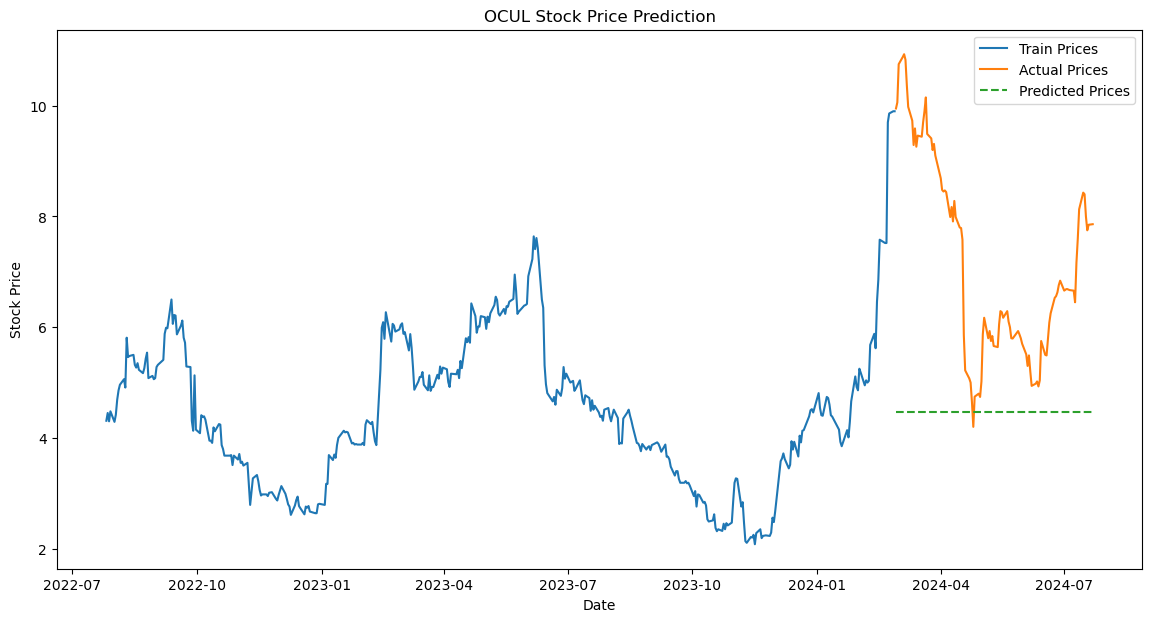

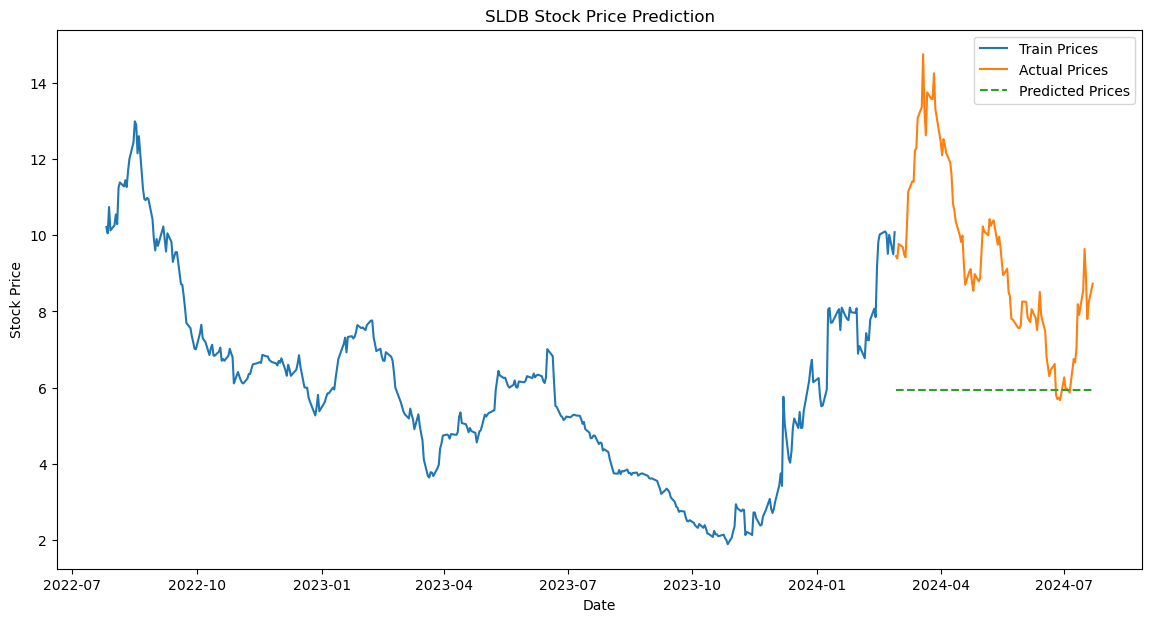

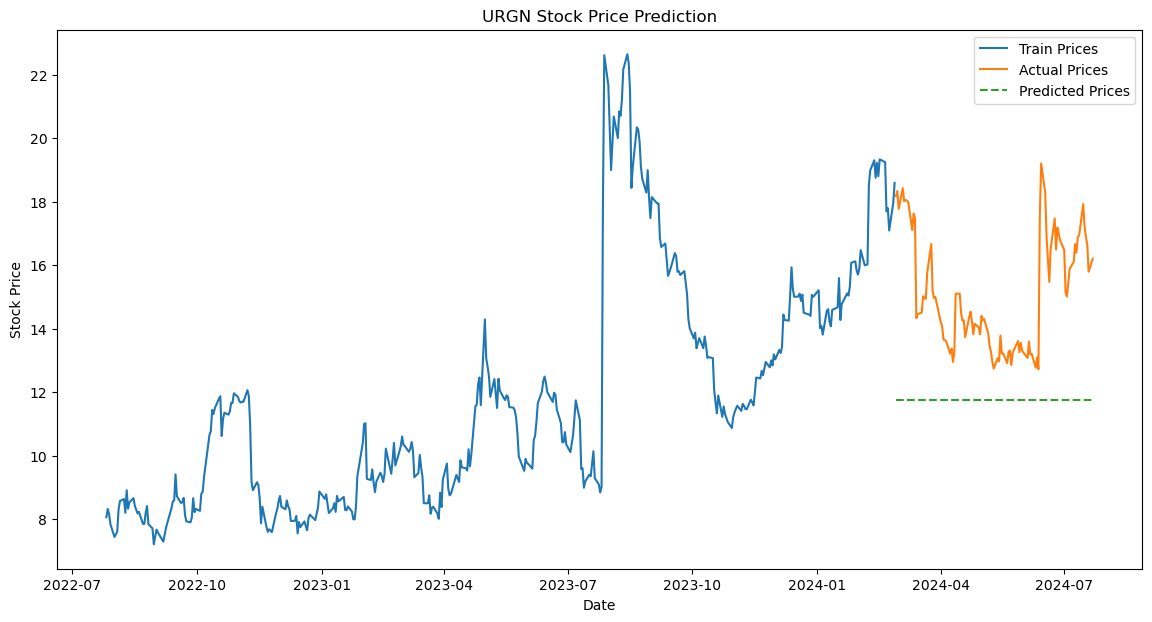

In [78]:
# Visualizing Dummy Regressor prediction.
def plot_predictions(model, y_train, X_test, y_test, stock):
    predictions = model.predict(X_test)
    plt.figure(figsize=(14, 7))
    plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Actual Prices')
    plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
    plt.title(f"{stock} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for the dummy regressor.
for stock in tech_list:
    X_train, X_test, y_train, y_test = split_data[stock]
    best_model = trained_models[stock]
    plot_predictions(best_model, y_train, X_test, y_test, stock)

# Modelling

### Machine Learning models: Random Forest and Decision Tree

In [79]:
# function to split df into train and test.
def ml_preprocess_data(df):
    X = df.drop(columns=['company_name', 'ticker_symbol', 'Close'])
    y = df['Close']
     # Calculate the split index
    split_index = int(len(df) * train_split_percentage)
    
    # Split the data into training and test sets
    # IMPORTANT NOTE: Add a 1 row lag between X and Y. The goal is to predict next days Close Price using past data.
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:-1]
    y_train = y.iloc[1:split_index+1]
    y_test = y.iloc[split_index+1:]
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

ml_processed_data = {}
for stock in tech_list:
    ml_processed_data[stock] = ml_preprocess_data(stock_data[stock])

In [80]:
# check to see shapes of train and test df and split correctly.
for i in range(4):
    print(ml_processed_data['OCUL'][i].shape)  #print(processed_data['OCUL'][i])

(400, 9)
(100, 9)
(400,)
(100,)


In [81]:
# Training Models function. We will explore Linear Regression, DecisionTree Regressor, and Random Forest Regressor.
def ml_train_models(X_train, y_train):
    models = {
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(n_estimators=100)
    }
    trained_models = {}
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[model_name] = model
    return trained_models

ml_trained_models = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_trained_models[stock] = ml_train_models(X_train, y_train)

In [84]:
def ml_evaluate_models(models, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        results[model_name] = {'MAE': mae, 'RMSE': rmse}
    return results

ml_evaluation_results = {}
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_evaluation_results[stock] = ml_evaluate_models(ml_trained_models[stock], X_test, y_test)

for stock, results in ml_evaluation_results.items():
    print(f"Evaluation results for {stock}:")
    for model_name, metrics in results.items():
        print(f"{model_name}: MAE = {metrics['MAE']}, RMSE = {metrics['RMSE']}")

Evaluation results for OCUL:
Decision Tree: MAE = 0.8647000407499997, RMSE = 1.1875352664402687
Random Forest: MAE = 0.5567745286040973, RMSE = 0.7439513192702546
Evaluation results for SLDB:
Decision Tree: MAE = 0.6560499993200001, RMSE = 0.8287953677408658
Random Forest: MAE = 0.5063575059780991, RMSE = 0.6573426125752424
Evaluation results for URGN:
Decision Tree: MAE = 0.8389999687, RMSE = 1.2386540663576158
Random Forest: MAE = 0.6557249682400004, RMSE = 0.9956472959620062


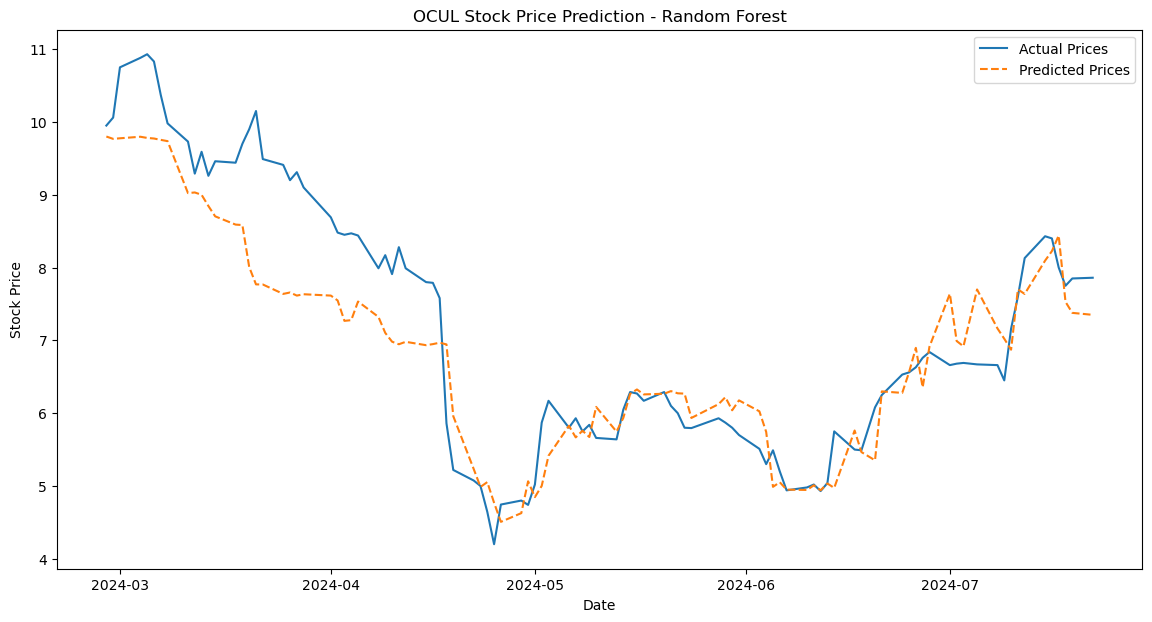

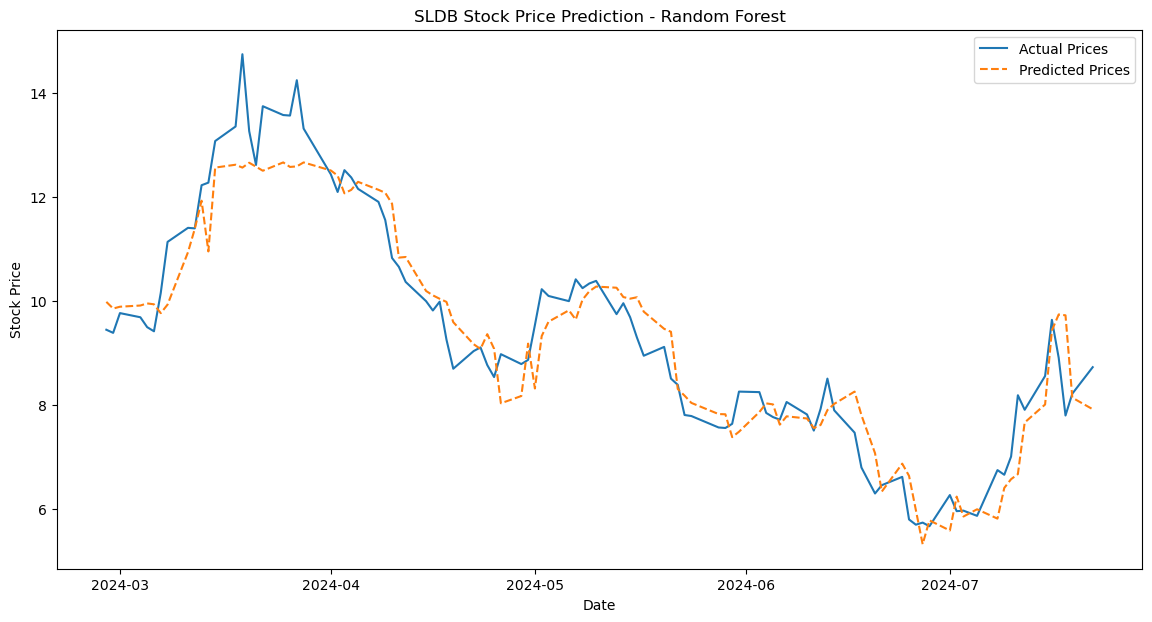

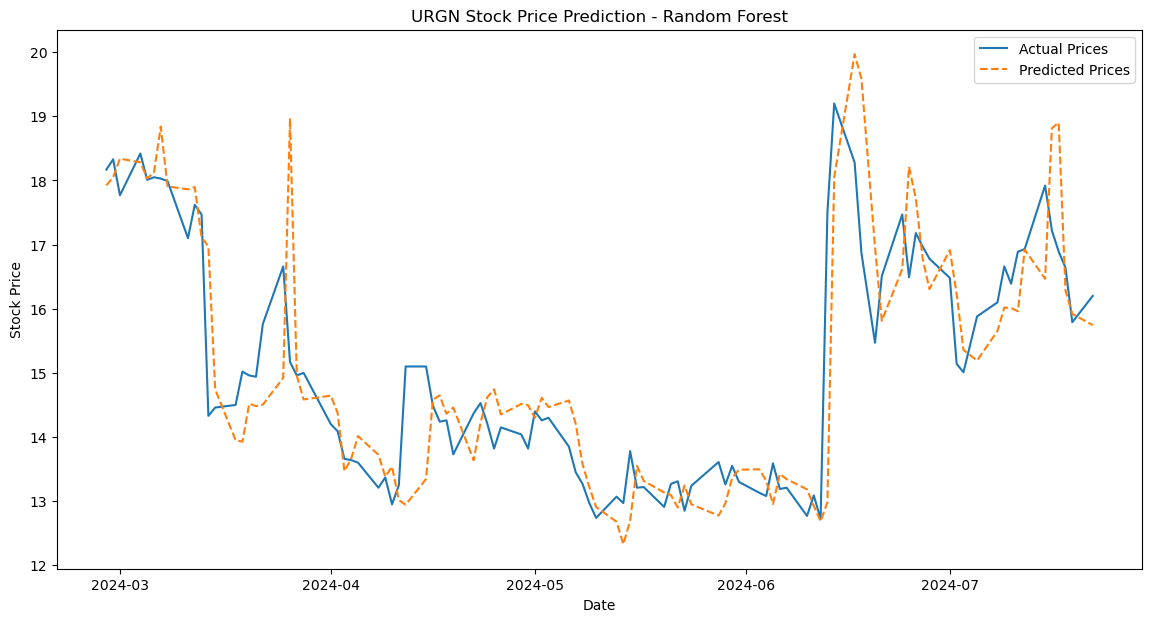

In [83]:
def ml_plot_predictions(model, y_train, X_test, y_test, stock):
    predictions = model.predict(X_test)
    #print(y_test, predictions)
    plt.figure(figsize=(14, 7))
    #plt.plot(y_train.index, y_train, label='Train Prices')
    plt.plot(y_test.index, y_test, label='Actual Prices')
    plt.plot(y_test.index, predictions, label='Predicted Prices', linestyle='--')
    plt.title(f"{stock} Stock Price Prediction - Random Forest")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Plot predictions for the best model (Random Forest in this example)
for stock in tech_list:
    X_train, X_test, y_train, y_test = ml_processed_data[stock]
    ml_best_model = ml_trained_models[stock]['Random Forest']
    ml_plot_predictions(ml_best_model, y_train, X_test, y_test, stock)

# Summary

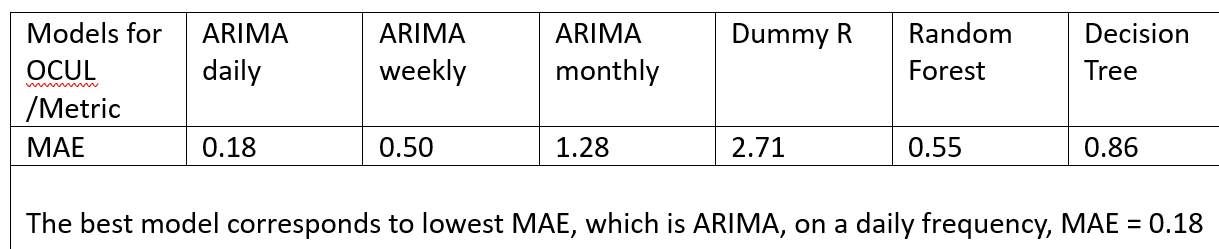

The daily frequency makes sense because the prediction is based on more recent data